In [2]:
import pandas as pd
import numpy as np
import os
STAT_P_126 = "data/stat_p_126.csv"
STAT_P_126_META = "data/STAT_P_126_Metadata.csv"

In [3]:
import re
import pandas as pd
data = pd.read_csv(STAT_P_126)
metadata = pd.read_csv(STAT_P_126_META)

display(data)
display(metadata['主要資料欄位'])

,item1,value1,value2,value3,value4,value5
0,112年 2月,...,...,...,...,...
1,112年 1月,...,...,...,...,...
2,111年 12月,942920,400175,503093,39651,1.308
3,111年 11月,923937,375509,507648,40781,1.326
4,111年 10月,928293,385122,501734,41437,1.29
...,...,...,...,...,...,...
153,100年 4月,621122,289336,264815,66971,0.894
154,100年 3月,630674,302931,261922,65822,0.878
155,100年 2月,579427,296920,218724,63782,0.893
156,100年 1月,669127,339905,262232,66990,0.932


0    item1(統計期)、value1(總產生量)、value2(一般垃圾量)、value3(資...
Name: 主要資料欄位, dtype: object

In [4]:
mask = data['item1'].apply(lambda chinese_date: '月' in chinese_date)
# Use the mask to split the data into two DataFrames
data_with_month = data[mask]
data_without_month = data[~mask]

# Print the first few rows of each DataFrame
print("Data with month:")
display(data_with_month.head())
print("\nData without month:")
display(data_without_month.head())

Data with month:


,item1,value1,value2,value3,value4,value5
0,112年 2月,...,...,...,...,...
1,112年 1月,...,...,...,...,...
2,111年 12月,942920,400175,503093,39651,1.308
3,111年 11月,923937,375509,507648,40781,1.326
4,111年 10月,928293,385122,501734,41437,1.29



Data without month:


,item1,value1,value2,value3,value4,value5
14,111年,11238654,4799426,5950352,488876,1.32
27,110年,10049062,3895153,5666869,487041,1.173
40,109年,9869675,4062029,5278079,529567,1.144
53,108年,9812418,4290856,5023517,498045,1.139
66,107年,9740671,4317339,4828340,594992,1.132


In [55]:
import re
def convert_date_regex(chinese_date):
    # Extract the year and month from the Chinese date using regex
    match = re.match(r'(\d+)年\s*(\d*)月*', chinese_date)
    
    if match:
        # The year is offset by 1911 because the original data is in the Republic of China calendar
        year = int(match.group(1)) + 1911
        month = match.group(2)
        # Convert the year and month to a datetime object
        return pd.to_datetime(f"{year}-{int(month)}")
    else:
        print(f"Problematic input: {chinese_date}")
        return None

def rename_columns(df: pd.DataFrame)-> pd.DataFrame:
    pattern = r'\(([\u4e00-\u9fff]+)\)' 
    headers = metadata['主要資料欄位']
    headers = headers.str.findall(pattern).tolist()[0]
    df.columns = headers
    return df

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df['date'] = df['item1'].apply(convert_date_regex)
    df = df.drop(columns=['item1'])
    return df

data = clean_data(data_with_month)
# Display the first few rows of the updated dataframe
data

,value1,value2,value3,value4,value5,date
0,...,...,...,...,...,2023-02-01
1,...,...,...,...,...,2023-01-01
2,942920,400175,503093,39651,1.308,2022-12-01
3,923937,375509,507648,40781,1.326,2022-11-01
4,928293,385122,501734,41437,1.29,2022-10-01
...,...,...,...,...,...,...
152,645598,305836,269215,70548,0.899,2011-05-01
153,621122,289336,264815,66971,0.894,2011-04-01
154,630674,302931,261922,65822,0.878,2011-03-01
155,579427,296920,218724,63782,0.893,2011-02-01


In [8]:
# Calculate summary statistics for compost data
summary_stats = data['value4'].describe()

# Print summary statistics
summary_stats

count           146
unique          144
top             ...
freq              2
Name: value4, dtype: object

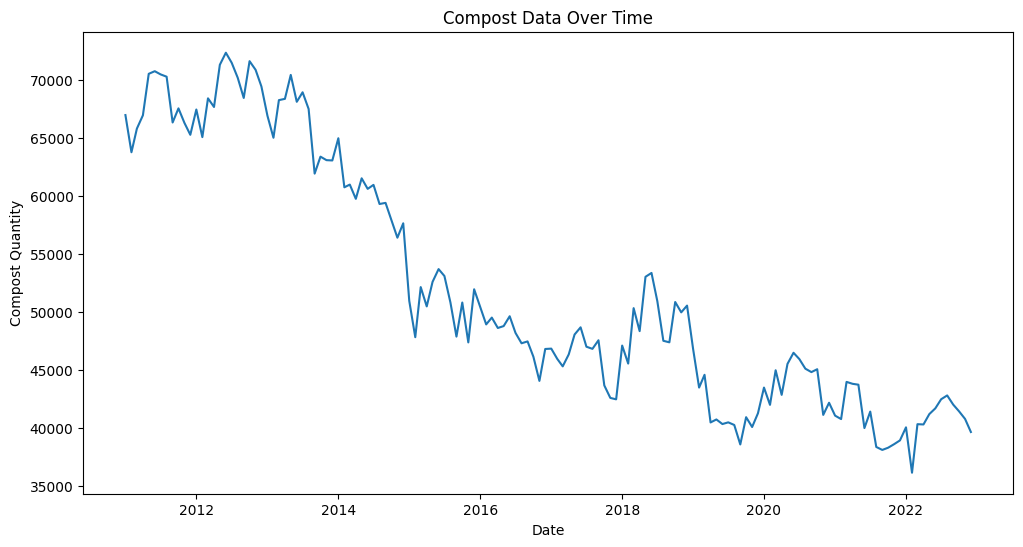

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'value4' column to numeric, coercing errors to NaN
data['value4'] = pd.to_numeric(data['value4'], errors='coerce')

# Create a line plot of compost data (value4) over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='date', y='value4')

plt.title('Compost Data Over Time')
plt.xlabel('Date')
plt.ylabel('Compost Quantity')
plt.show()

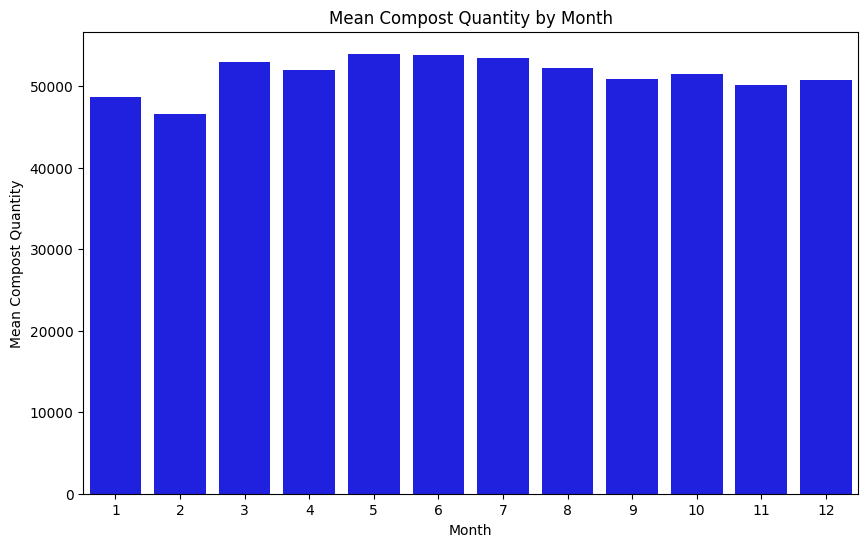

In [73]:
data_copy = data.copy()
# data.set_index('date', inplace=True)
data_copy.set_index('date', inplace=True)
data_monthly = data_copy['value4'].resample('MS').asfreq()
# Extract the month from the date
data_monthly = data_monthly.reset_index()
# set NaN to 0
data_monthly['value4'] = data_monthly['value4'].fillna(0)
data_monthly['month'] = data_monthly['date'].dt.month
# # Calculate the mean compost quantity for each month
monthly_means = data_monthly.groupby('month')['value4'].mean()

# Plot the mean compost quantity for each month
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_means.index, y=monthly_means.values, color='b')
plt.xlabel('Month')
plt.ylabel('Mean Compost Quantity')
plt.title('Mean Compost Quantity by Month')
plt.show()